$\textbf{Data generation for QRNG using Gaussian Boson Sampling}$

An alternative to the original Boson Sampling scheme is Gaussian boson sampling where single-mode squeezing operations are used. This has been proved to correspond to solving the boson sampling problem but with the advantage of the possibility of generating simultaneously, single mode squeezed states in a determinist way. All the steps previously used in the original boson sampling scheme are gonna be present in this notebook a comparison of both schemes outside of hardware scalability will be made.


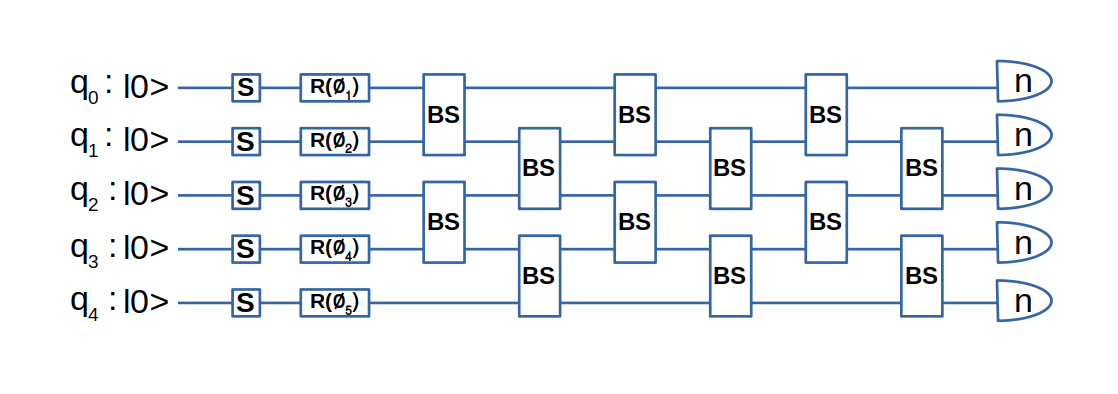

A five-single mode squeezed state is sent into the same linear interferometer and 600 output samples are collected using the $\textit{gaussian}$ backend and stored into data to be processed in the next notebook. The possible output strings are much harder to predict because the squeezing operation generated pairs of photons with a Poissonian distribution with the highest probability being the generation of no photon. This means that only output states with an even total number of photons will be generated:  vacuum state will be the most probable output and we can have more photons than the number of modes with usually quite low probability.

$\textbf{Random unitar matrix}$

In [1]:
from scipy.stats import unitary_group
import numpy as np

# creating a Haar random unitary Matrix using scipy
#--------------------------------------

# set the random seed 
# to ensure we get always the same random unitary matrix
np.random.seed(42)
#np.random.seed(177)
#np.random.seed(43)

# define the random complex unitary matrix of dimension 5 for the linear interferometer
U = unitary_group.rvs(5)

print(U)

[[ 0.20433962+0.04563164j -0.02361519-0.36173515j  0.26719021+0.04221819j
   0.27730975-0.07781071j -0.68043314+0.45347065j]
 [-0.0963199 -0.24753171j  0.55770976+0.58623734j  0.27070627+0.10086774j
  -0.16546696-0.31386425j -0.16575925+0.19471451j]
 [-0.19064203-0.50223399j -0.12383912-0.02478472j -0.14823601-0.67749106j
  -0.06714246-0.09148585j -0.36494647-0.26159983j]
 [-0.23131538+0.3037924j  -0.41811028+0.07338673j  0.43289245+0.01826825j
  -0.66041604+0.02964243j -0.2140438 -0.05855927j]
 [ 0.60294259-0.29613147j  0.04674194-0.12465382j -0.35544265+0.21984925j
  -0.58144165+0.05634298j -0.11566324+0.04174832j]]


$\textbf{State preparation for Gaussian Boson Sampling }$

In [2]:
import strawberryfields as sf
from strawberryfields.ops import *

# initialize a 5 mode program
gbs = sf.Program(5)

with gbs.context as q:
    # prepare the input squeezed states
    S = Sgate(1)
    S | q[0]
    S | q[1]
    S | q[2]
    S | q[3]
    S | q[4]

    # apply a random linear interferometer
    Interferometer(U) | q
    # Measurement
    MeasureFock()     | q

The measurement of the output state, in this case, is done using the $\textit{gaussian}$ backend. The probability of the output states is not influenced by the measure in the circuit in this backend.

$\textbf{Output probability distribution}$

Since the squeezing Operations spawn an infinite dimension on the basis of the fock states with an even number of photons, considering all possible states of the output regardless of the probability distribution is impossible. For that, we set up some reasonable limits. To list all the possible outputs, we define all possible states with a max of 8 photons for each mode cutting off to a maximum of 10 photons total in output states. This is a reasonable simplification since most states that don't fit these conditions will have a negligible probability. And at least, to go even further, we only take states with a probability bigger than $0.001$. Let us note that these conditions are only used to generate a part of the probability distribution of the Gaussian boson sampler and in no way will be used when generating the samples later.
The probability of the fock states can be then obtained using the $\textit{state.fock_prob}$.

In [3]:
# Fock states to measure at output
# List all the possible outputs
# I define all possible states 
# with max 8 photons for each photons
# cuting of to maximum 10 photons total in output states

measure_states=[] # empty list to store the filtered output states
for i in range(8):
    for j in range(8):
        for k in range(8):
            for l in range(8):
                for m in range(8):
                    if i+j+k+l+m <10:
                        # this is ensure only output with an even number of photons are taken
                        # output state with an odd number of photon have a zero probability
                        if (i+j+k+l+m) % 2 == 0: 
                            measure_states.append([i,j,k,l,m])

# using Gaussian backend
eng = sf.Engine(backend="gaussian",backend_options={"cutoff_dim":10})
results = eng.run(gbs)

# cutting off all the states with a probability lower than 0.001
# and save the states in the form of string and their respective probability
probability_margin =10**-3 
probabil=[] #empty # list to probabilities
states=[] # empty list to store the strings
for i in measure_states:
    prob = results.state.fock_prob(i)
    if prob < probability_margin:
        measure_states.remove(i)
    else:
        notation="|{}>".format("".join(str(j) for j in i))
        #print("|{}>: {}".format("".join(str(j) for j in i), prob))
        probabil.append(prob)
        states.append(notation)

# get the sum of the probability distribution
# this will give us the percentage of the probability distrubution that accounts for the filtered states
print("The sum of the probability of the filtered states =",sum(probabil))

The sum of the probability of the filtered states = 0.37665226410770386


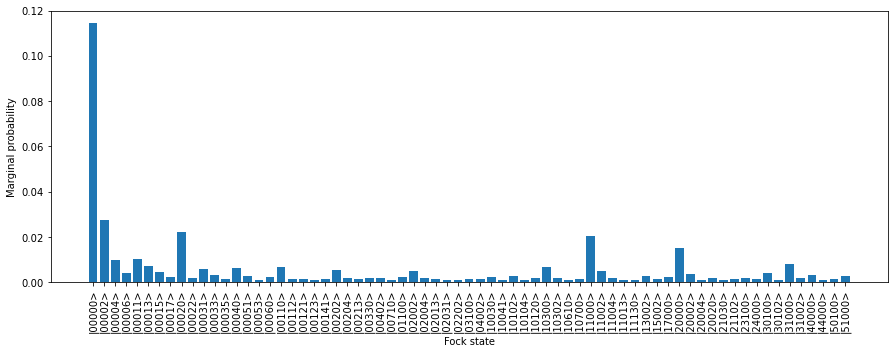

In [8]:
# plotting the probability distribution obtained
from matplotlib import pyplot as plt
fig,ax = plt.subplots()
plt.bar(states,probabil)
plt.rcParams["figure.figsize"] = (15,5)
plt.xticks(rotation= 90)
plt.xlabel('Fock state')
plt.ylabel('Marginal probability')
plt.show()

As we expected, we have a large probability distribution dominated by the vacuum state. We also have a large distribution. It would be nice for us to compare it with the original boson sampler using the entropy defined previously. But since only the filtered output states only account for 37% of the whole probability distribution, that comparison would be meaningless. We will therefore attempt to do so after post-processing while expecting Gaussian Boson sampling to be performed better or slightly worse. In the latter, it would still be the preferred implementation hardware thanks to its scalability.

$\textbf{Measurement results}$

To get the measurement results in Gaussian boson sampling, we still use the Gaussian backend for photon counting. The Gaussian backend being quite optimized in strawberryfields, we don't really need to put a $\textit{cutood_dim}$.


In [4]:
### Measurement results 
# -----------------------------
import time

# get the start time
st = time.time()

# Get output samples using gaussian backend (photon counting)
#eng = sf.Engine(backend="gaussian",backend_options={"cutoff_dim":10})

n = 600 # number of samples

def output_pp():
    eng = sf.Engine(backend="gaussian")
    results = eng.run(gbs)
    return np.ravel(results.samples)
sample = [output_pp() for i in range(n)]

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

#Be careful when running this because it might take some time.

Execution time: 23.971578121185303 seconds


It took around 24s to generate the 600 samples meaning a rate of 1 sample per 40 milliseconds. This is much much faster than the fock backend, we suspect it's becasue the gaussian backend is much more optimized than the fock one in strawberry field, due to the software being more optimized for continuous variable quantum information.

The next cell takes the $textit{sample}$ list and save it in a CVS archive, which name is formatted using the number of the seed and the number of photons.Be careful to change the name ofthe file if you dont want to erase the files that are already in there. Every run is of 600 samples.

In [6]:
import numpy as np
  
# from the numpy module
# sava the datas into an cvs file
np.savetxt("data/seed42_gbs.csv", 
           sample,
           delimiter =", ", 
           fmt ='% s')

These data will be used to assess the quality of the Quantum Random Number Generator based on our boson sampling process, after post-processing.

In the case of Gaussian Boson sampling, the testing case correspond was done considering equal squeezing parameters for each mode. There is the possibility to choose different squeezing parameters and see how they influence the probability distribution before post-processing. Similarly to what we did with the original boson sampling scheme but manipulating the parameters of the unitary matrix.

$\textbf{Possible improvement}$

In the case of Gaussian Boson sampling, the testing case correspond was done considering equal squeezing parameters for each mode. There is possibility to choose different squeezing parameters and see how they influence the probability distribution before post processing.
